In [1]:
import os
import torch
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
%matplotlib inline

/datasets/home/home-00/06/206/j1burke/ECE285/ECE285_Sauvage_Object_Detection/model/utils/nms/non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')


In [2]:
img = read_image('RCNN/dog-cycle-car.png')
img = torch.from_numpy(img)[None]
model_dir = 'checkpoints/'

In [3]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Exception in user code:
------------------------------------------------------------


In [4]:
from PascalVOCDataloader import PascalVOCDataloader, create_split_loaders
data_dir = '/datasets/ee285f-public/PascalVOC2012/'
dataset = PascalVOCDataloader(data_dir)
train_loader, val_loader, test_loader = create_split_loaders(data_dir,batch_size=1)

1.0


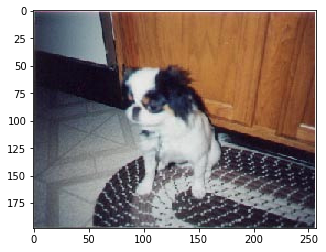

In [5]:
trainer.load(model_dir+'fasterrcnn_06071842.pth')
img, q, e = next(iter(test_loader))
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

In [22]:
from IoU import bb_intersection_over_union
import numpy as np
import time
# loop over images
def calc_TP_FP_FN(true_vals, predicted_vals, class_labels):
    true_bbooxes, true_labels = true_vals
    predicted_bboxes, predicted_labels = predicted_vals
    mAP_thresh = 0.5
    n_classes = len(class_labels)
    TP = np.zeros((n_classes))
    FP = np.zeros((n_classes))
    FN = np.zeros((n_classes))
    n_pred_bboxes = predicted_bboxes.shape[0]
    for c in class_labels:
        class_ind = (true_labels == c)
        n_bboxes = np.sum(class_ind)
        class_bboxes = true_bbooxes[class_ind]
        for b in range(n_bboxes):
            # Calculate iou between ground truth and predictions
            iou = np.zeros((n_pred_bboxes))
            for pb in range(n_pred_bboxes):
                iou[pb] = bb_intersection_over_union(class_bboxes[b], predicted_bboxes[pb])
            # Calculate True Positives
            n_true_pos = np.sum(np.logical_and(predicted_labels == c, iou >= mAP_thresh))
            if n_true_pos == 1:
                TP[c] += 1
            elif n_true_pos > 1:
                TP[c] += 1
                FP[c] += n_true_pos - 1
            else:
                FN[c] += 1
            # Calculate False Positives
            n_false_pos = np.sum(np.logical_and(predicted_labels != c, iou >= mAP_thresh))
            FP[c] += n_false_pos
            
    return (TP, FP, FN)

class_labels = [i for i in range(20)]

img, true_bboxes, true_labels = next(iter(test_loader))

pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)
true_bboxes, true_labels = true_bboxes.numpy()[0], true_labels.numpy()[0]
pred_bboxes, pred_labels = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0]


calc_TP_FP_FN((true_bboxes, true_labels), (pred_bboxes, pred_labels), class_labels)

# it takes .2 seconds to load data and .6 seconds to run prediction


0.8768160343170166
0.0007367134094238281


In [30]:
n_classes = 20
class_labels = [i for i in range(n_classes)]
#True_Positives = np.zeros((n_classes))
#False_Positives = np.zeros((n_classes))
#False_Negatives = np.zeros((n_classes))
for minibatch_count, (img, true_bboxes, true_labels) in enumerate(test_loader, 0):
    pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)
    true_bboxes, true_labels = true_bboxes.numpy()[0], true_labels.numpy()[0]
    pred_bboxes, pred_labels = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0]
    TP, FP, FN = calc_TP_FP_FN((true_bboxes, true_labels), (pred_bboxes, pred_labels), class_labels)
    True_Positives = np.add(True_Positives, TP)
    False_Positives = np.add(False_Positives, FP)
    False_Negatives = np.add(False_Negatives, FN)
    #print(minibatch_count)
    if minibatch_count > 1000:
        break

Precision = np.zeros((n_classes))
Recall = np.zeros((n_classes))
for i in range(n_classes):
    if (True_Positives[i] + False_Positives[i]) != 0:
        Precision[i] = True_Positives[i]/(True_Positives[i] + False_Positives[i])
    if (True_Positives[i] + False_Negatives[i]) != 0:
        Recall[i] = True_Positives[i]/(True_Positives[i] + False_Negatives[i])
#np.divide(TP, np.add(TP, FP))
#np.divide(TP, np.add(TP, FN))
print(Precision)
print(Recall)

#start_time = time.time()
#print(time.time() - start_time)

[0.87878788 0.53333333 0.47619048 0.75       1.         0.84848485
 0.96296296 0.85714286 0.33333333 0.3125     0.72727273 0.92941176
 0.11111111 0.75       0.98705882 1.         0.2173913  0.80645161
 0.85714286 1.        ]
[0.38666667 0.125      0.16949153 0.08333333 0.14285714 0.71794872
 0.34899329 0.45       0.03571429 0.11627907 0.29090909 0.60769231
 0.03508772 0.27777778 0.64988381 0.1038961  0.05319149 0.36231884
 0.375      0.4137931 ]


In [14]:
print(len(test_loader)*elapsed_time/3600)

0.7214999477068583


In [32]:
### WRONG WAY ###

n_classes = 20
class_labels = [i for i in range(n_classes)]
#True_Positives = np.zeros((n_classes))
#False_Positives = np.zeros((n_classes))
#False_Negatives = np.zeros((n_classes))
score_thresh = [0.2, 0.4, 0.6, 0.8]
Total_P = []
Total_R = []
for thresh in score_thresh:
    for minibatch_count, (img, true_bboxes, true_labels) in enumerate(test_loader, 0):
        pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=thresh)
        true_bboxes, true_labels = true_bboxes.numpy()[0], true_labels.numpy()[0]
        pred_bboxes, pred_labels = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0]
        TP, FP, FN = calc_TP_FP_FN((true_bboxes, true_labels), (pred_bboxes, pred_labels), class_labels)
        True_Positives = np.add(True_Positives, TP)
        False_Positives = np.add(False_Positives, FP)
        False_Negatives = np.add(False_Negatives, FN)
        #print(minibatch_count)
        if minibatch_count > 100:
            break
    
    Precision = np.zeros((n_classes))
    Recall = np.zeros((n_classes))
    for i in range(n_classes):
        if (True_Positives[i] + False_Positives[i]) != 0:
            Precision[i] = True_Positives[i]/(True_Positives[i] + False_Positives[i])
        if (True_Positives[i] + False_Negatives[i]) != 0:
            Recall[i] = True_Positives[i]/(True_Positives[i] + False_Negatives[i])
    ave_precision = np.mean(Precision)
    ave_recall = np.mean(Recall)
    Total_P.append(ave_precision)
    Total_R.append(ave_recall)
    print('For score_thresh=%.2f, Precision=%.2f, Recall=%.2f' %(thresh, ave_precision, ave_recall))

#np.divide(TP, np.add(TP, FP))
#np.divide(TP, np.add(TP, FN))
print(Precision)
print(Recall)


For score_thresh=0.20, Precision=0.71, Recall=0.31
For score_thresh=0.40, Precision=0.71, Recall=0.31
For score_thresh=0.60, Precision=0.71, Recall=0.32
For score_thresh=0.80, Precision=0.71, Recall=0.31
[0.88372093 0.62962963 0.61111111 0.69230769 0.9        0.86486486
 0.96153846 0.80821918 0.36363636 0.36363636 0.66666667 0.88135593
 0.23333333 0.80645161 0.97688889 1.         0.24       0.725
 0.6969697  0.97368421]
[0.37623762 0.20238095 0.26190476 0.08823529 0.14634146 0.68085106
 0.36231884 0.48760331 0.06472492 0.17647059 0.32911392 0.61176471
 0.09459459 0.37313433 0.64876033 0.11428571 0.06122449 0.35802469
 0.37704918 0.44578313]


In [ ]:
n_classes = 20
class_labels = [i for i in range(n_classes)]
#True_Positives = np.zeros((n_classes))
#False_Positives = np.zeros((n_classes))
#False_Negatives = np.zeros((n_classes))
for minibatch_count, (img, true_bboxes, true_labels) in enumerate(test_loader, 0):
    pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)
    true_bboxes, true_labels = true_bboxes.numpy()[0], true_labels.numpy()[0]
    pred_bboxes, pred_labels = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0]
    TP, FP, FN = calc_TP_FP_FN((true_bboxes, true_labels), (pred_bboxes, pred_labels), class_labels)
    True_Positives = np.add(True_Positives, TP)
    False_Positives = np.add(False_Positives, FP)
    False_Negatives = np.add(False_Negatives, FN)
    #print(minibatch_count)
    if minibatch_count > 1000:
        break

Precision = np.zeros((n_classes))
Recall = np.zeros((n_classes))
for i in range(n_classes):
    if (True_Positives[i] + False_Positives[i]) != 0:
        Precision[i] = True_Positives[i]/(True_Positives[i] + False_Positives[i])
    if (True_Positives[i] + False_Negatives[i]) != 0:
        Recall[i] = True_Positives[i]/(True_Positives[i] + False_Negatives[i])
#np.divide(TP, np.add(TP, FP))
#np.divide(TP, np.add(TP, FN))
print(Precision)
print(Recall)
#images = 2*images/255 -1

TypeError: 'enumerate' object is not subscriptable